In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# House prices - Advanced Regression Techniques

Checklist of what to do:
1. Basic data cleaning and feature exploration
2. Exploratory data analysis (looking at the relationships between features and target variable)
3. Data Engineering (Building pipelines that automate data preprocessing on both training and test datasets)
4. Deploying baseline machine learning models (Linear Regression, Random Forest, XGBoost)
5. Feature engineering, trying to improve our models
6. Ensembling
 

In [2]:
#basic packages to import

import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as stats
from IPython.display import display, HTML

# Basic Data Exploration
1. Load the dataset
2. Look at summary statistics
3. Check Null values and ask why they're there, and how to deal with them

In [3]:
# Function to create scrollable table within a small window
def create_scrollable_table(df, table_id, title):
    html = f'<h3>{title}</h3>'
    html += f'<div id="{table_id}" style="height:200px; overflow:auto;">'
    html += df.to_html()
    html += '</div>'
    return html

In [4]:
df = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Just at first glance, we can clearly see that there are a few columns that are plagued with NaN values, like PoolQC, Fence, MiscFeature, we'll go about them later

In [5]:
df.shape

(1460, 81)

**Check missing values**

Let's check how many null values are there in each column/feature

In [6]:
dfnull_values = df.isnull().sum()

#show only features that contain null values
html_null_values = create_scrollable_table(dfnull_values[dfnull_values != 0].to_frame(), "", "Total missing values for each feature")

display(HTML(html_null_values))

,0
LotFrontage,259
Alley,1369
MasVnrType,872
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtExposure,38
BsmtFinType1,37
BsmtFinType2,38
Electrical,1


In [7]:
missing_percentage = dfnull_values[dfnull_values != 0] * 100 / len(df)
html_null_values = create_scrollable_table(missing_percentage.to_frame(), "", "Percentage of missing values for each feature")

display(HTML(html_null_values))

,0
LotFrontage,17.739726
Alley,93.767123
MasVnrType,59.726027
MasVnrArea,0.547945
BsmtQual,2.534247
BsmtCond,2.534247
BsmtExposure,2.602740
BsmtFinType1,2.534247
BsmtFinType2,2.602740
Electrical,0.068493


**Why do certain features have more null values than the others?**
1. Some features contain null values because they just aren't recorded
2. While some features just don't exist (For instance, 99.5% of rows didn't have PoolQC data, a possible explanation would be most houses don't have pools)

This affects our method of imputing missing/null values

**Basic separation of categorical and numerical features**

What do I mean by basic?

Certain features are represented numerically, however they have different context.

For instance,
The feature "MSSubClass" is represented numerically, but it can only take specific values and not a continuous range of values.

From the data_description.txt:
Value 20 means: 1-STORY 1946 & NEWER ALL STYLES

In [8]:
#basic separation for now
numerical_features = df.select_dtypes(include = [np.number])
categorical_features = df.select_dtypes(include = [object])


In [9]:
num_cols = numerical_features.columns

In [10]:
cat_cols = categorical_features.columns
df[cat_cols]


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [11]:
#summary stats for numerical features
numerical_features_stats = numerical_features.describe().T
html_numerical = create_scrollable_table(numerical_features_stats, 'numerical_features', 'Summary statistics for numerical features')

display(HTML(html_numerical))

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [12]:
#summary stats for categorical features
categorical_features_stats = categorical_features.describe().T
html_categorical = create_scrollable_table(categorical_features_stats, 'categorical_features', 'Summary statistics for categorical features')

display(HTML(html_categorical))

,count,unique,top,freq
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
Alley,91,2,Grvl,50
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225
Condition1,1460,9,Norm,1260


What I like to do is to keep note of the column names

In [13]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# Exploring the target variable (SalePrice)

It is crucial to carry out analysis of the variable that we're trying to predict, at the same time we can learn more about the dataset, like the relationships between features and the target variable.

Things I will cover in this part of the analysis:
1. The distribution of the data
2. What are the relationships between the features and the target variable

In [14]:
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from scipy import stats
from scipy.stats import norm
import warnings
import matplotlib.pyplot as plt
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn



 mu = 180921.20 and sigma = 79415.29



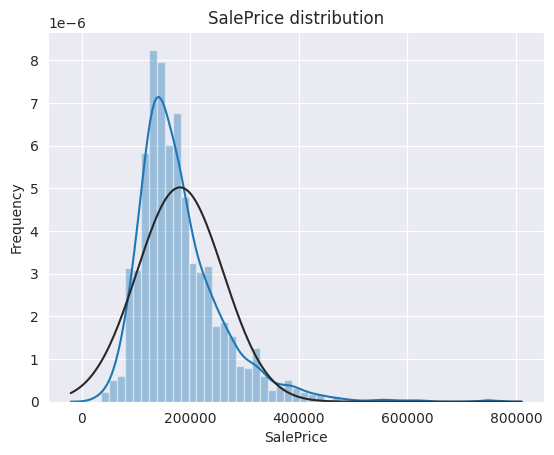

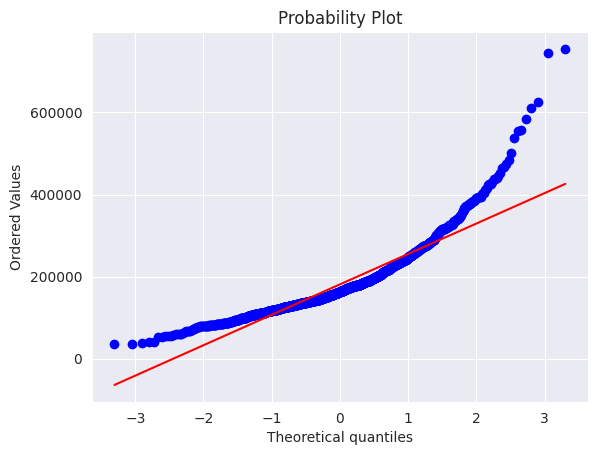

In [15]:
sns.distplot(df['SalePrice'] , fit=norm)
(mu, sigma) = norm.fit(df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)
plt.show()

From both the distribution and QQ plots above, we can tell that the target variable is right skewed (QQ plot curving upward to the right

Below will demonstrate a transformation of the target variable, also known as log transformation, with normalizes the distribution of the target variable. However, this section is only for demonstration purposes, the actual transformation will be later implemented in a pipeline so future datasets will be automatically transformed.

In [16]:
y_norm = np.log(df['SalePrice'])


 mu = 12.02 and sigma = 0.40



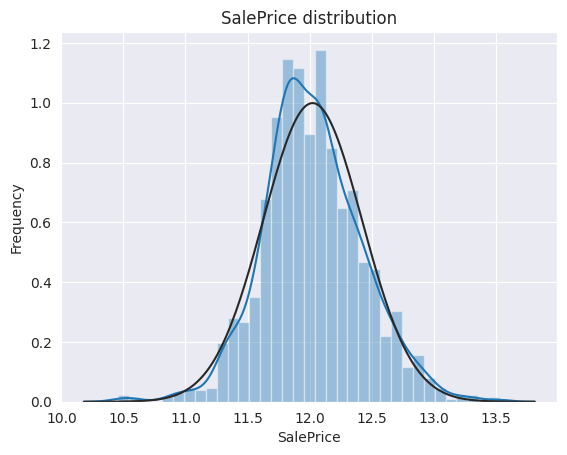

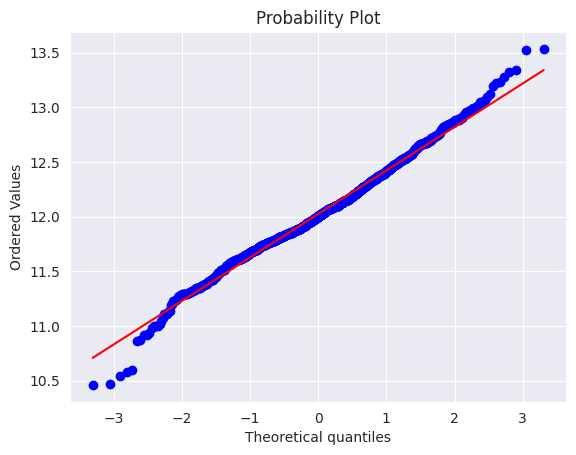

In [17]:
#Check the new distribution 
sns.distplot(y_norm , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_norm)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(y_norm, plot=plt)
plt.show()

Asking questions is a key component of discovering relationships between features and target variable. For instance,
1. What are the average prices of building types?
2. Does general zoning classification of the sale have anything to do with the sale price?

Text(0.5, 1.0, 'Average price for each type of building')

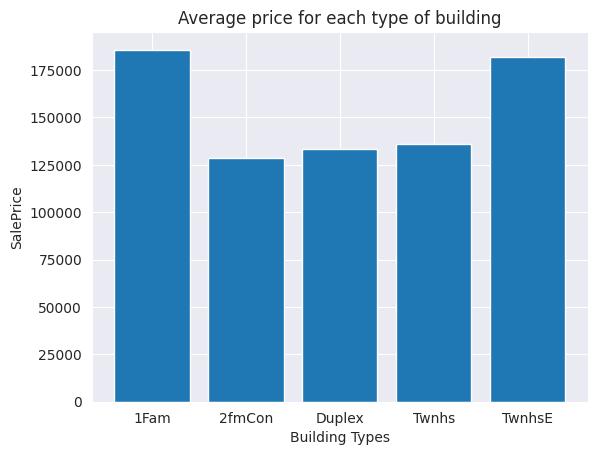

In [18]:
# reset_index so we can specify x and y axis
building_price = df.groupby('BldgType')['SalePrice'].mean().reset_index()

plt.bar(building_price['BldgType'], building_price['SalePrice'])
plt.xlabel('Building Types')
plt.ylabel('SalePrice')
plt.title('Average price for each type of building')

In [19]:
df['MSZoning'].value_counts()

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

Since the data distribution for this feature is heavily skewed, not enough data points for other classification, I chose to not study this feature in relation to the 'SalePrice'

Text(0.5, 1.0, 'Average sale price in neighborhood')

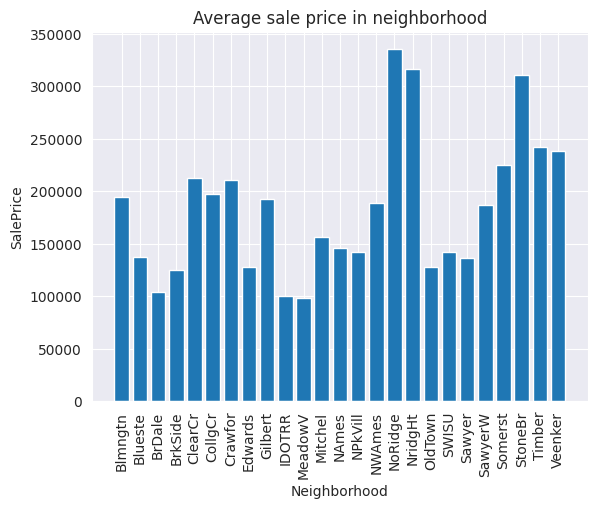

In [20]:
neighborhood = df.groupby('Neighborhood')['SalePrice'].mean().reset_index()

plt.bar(neighborhood['Neighborhood'], neighborhood['SalePrice'])
plt.xticks(rotation=90)
plt.xlabel('Neighborhood')
plt.ylabel('SalePrice')
plt.title('Average sale price in neighborhood')

Why are some neighborhoods more expensive than the others?
Few factors may include:
1. Safety
2. Transport
3. Public amenities
4. Average income

Safety data can be acquired externally, for instance crime rate, but for the purpose of this project, we will keep it simpler.

# Building a Data Pipeline

Building a data pipeline will ensure that we have a consistent infrastructure for transforming the test set, and who knows, maybe next time when we acquire updated datasets of the same format, our pipeline will be of great use.

Things to do:
1. Feature transformation
2. Dealing with missing values
3. Feature engineering


**Feature transformation**

Before dealing with missing values, we need to make sure that the features are well interpreted.

- Certain features may have numerical values, but they aren't continuous numerical values, ie, they only take specific values. In our case, the feature 'MSSubClass' only takes 15 specific numerical values

- 'OverallQual' contains values from 1-10, which represents the overall quality of building, 1 being very poor and 10 being very excellent. We have to make sure our machine learning model interprets it corrrectly

**Checklist**, data types:
1. Numerical
2. Nominal
3. Numerical BUT categorical
4. Ordinal

Our pipeline must make sure that our dataframe consists of the correct data types before imputing missing values

In [21]:
print(f"There are only {len(df['MSSubClass'].unique())} specific numerical values for feature MSSubClass")

There are only 15 specific numerical values for feature MSSubClass


# Data Preprocessing

In this section, we will be performing basic data preprocessing.

1. Deal with missing values
2. Scaling
3. One hot encoding for categorical features WITHOUT ordinal relationships
4. Label encoding for categorical features WITH ordinal relationships
5. Certain features should be dropped (too many missing values/useless features)


In [27]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [31]:
# 1. Separating target variable and features
# 2. Removing features that are not helpful in predicting the target variable, reasons include, too many missing values, useless features (ID)
rm_features = ["Alley", "MasVnrType", "Id", "SalePrice", "FireplaceQu", "PoolQC", "Fence", "MiscFeature"]

y = df["SalePrice"]
X = df.drop(rm_features, axis=1)
X.shape

(1460, 73)

In [34]:
# This section is to separate numerical and categorical features again for one hot encoding
numerical_features = X.select_dtypes(include = [np.number])
categorical_features = X.select_dtypes(include = [object])

num_cols = numerical_features.columns
cat_cols = categorical_features.columns

In [36]:
# Perform feature scaling and imputing missing values

In [35]:
#performing one hot encoding on ALL categorical features

X_encoded = pd.get_dummies(data = X, prefix = cat_cols, columns = cat_cols)
X_encoded.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,False,False,False,True,False,False,False,False,True,False
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,False,False,False,True,False,False,False,False,True,False
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,False,False,False,True,False,False,False,False,True,False
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,False,False,False,True,True,False,False,False,False,False
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,False,False,False,True,False,False,False,False,True,False


# Deploying basic machine learning models as baseline
We'll not be scaling or imputing our training data and will be directly used in our machine learning models.

Machine Learning models that we will be using in this project are:

1. Linear Regression
2. Random Forest
3. XGBoost
4. Neural Networks



In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


Since our models have both numerical and categorical features, in this case, for our baseline model, we will be simplifying the process, and apply one-hot-encoding to all categorical features. Later on, we will classify both numerical and categorical features accordingly.

For instance, there are categorical features that have ordinal relationships, a one-hot-encoder would not be suitable in this case, hence a labelencoder should be used instead.

In [24]:
## Before we use linear regression, we gotta use one-hot-encoding, because linear regression only takes numerical values

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=1)

print(X_train.shape)
print(X_train)

(1022, 287)
      MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
632           20         85.0    11900            7            5       1977   
208           60          NaN    14364            7            5       1988   
83            20         80.0     8892            5            5       1960   
1174          70         80.0    16560            6            8       1932   
250           30         55.0     5350            3            2       1940   
...          ...          ...      ...          ...          ...        ...   
715           20         78.0    10140            6            5       1974   
905           20         80.0     9920            5            5       1954   
1096          70         60.0     6882            6            7       1914   
235          160         21.0     1680            6            3       1971   
1061          30        120.0    18000            3            4       1935   

      YearRemodAdd  MasVnrArea  BsmtFin

In [25]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# Random Forest


In [26]:
rfr_model = RandomForestRegressor(random_state=1)
rfr_model.fit(X_train, y_train)
y_pred = rfr_model.predict(X_test)
#mse = mean_squared_error(y_test, y_pred[0])
rmse = np.sqrt(mean_squared_error(y_test[:5], y_pred[:5]))
print(y_test[:5])
print(y_pred[:5])
print(rmse)

ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values